Full testing/ training of 

LinearRegression, KNeighborsRegressor, and keras CNN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
from collections import Counter
from scipy import signal
from pathlib import Path
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [19]:
# Run this to get started
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')


dictionary_aurora_50_sampled_path = "measurements_auscultatory_dictionary_ALL.pkl"
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"
participants_data =  path_aurora_dataset / "participants.tsv"


# Use pwdb_model_configs file
participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")




with open(dictionary_aurora_50_sampled_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]




keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [ ]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y



# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,120), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]

def LinearRegression_plot_MAE( activity_number=1):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)

    all_points = np.array(auscultatory_pressure)
    all_points = all_points.reshape(all_points.shape[0], -1)

    plt.figure(figsize=(5, 5)) 
    neigh = LinearRegression()


    X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_dbp, test_size=0.3)




    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    plt.rcParams.update({'font.size': 10})

    plt.plot(Y_test, Y_test, color="grey", linewidth=2, alpha=0.9)


    plt.scatter(Y_test, list(y_predict),  color="red",  alpha=0.5,s=50 )
    plt.title(f"LinearRegression Activity: {keys_for_grouping[activity_number]}")
    plt.xlabel("Tested DBP value")
    plt.ylabel("Predicted DBP value")

    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    plt.show()
    return round(mean_absolute_error(Y_test, y_predict),2)


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_test= np.array(X)
        Y_test= np.array(Y)
        
        X_train= np.array(X_other)
        Y_train= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))


            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        

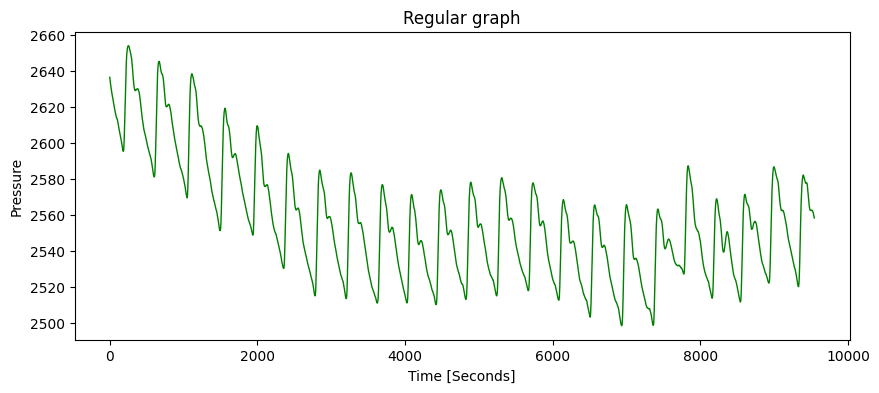

In [20]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "green")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

In [ ]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

In [ ]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [ ]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

In [ ]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="grey" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

In [ ]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


In [ ]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

Making the chart for aurora

In [ ]:

# LinearRegression_MAE_cross(-1, "s",1000)

# KNN_MAE_cross(-1, "s",1000)

# CNN_MAE_cross(-1, "s",1000)

# #or Run no overlap in participants , 0=Calibration_start recordings

# LinearRegression_MAE_cross(0, "s",50)

# KNN_MAE_cross(0, "s",50)

# CNN_MAE_cross(0, "s",50)



Done with Auroa and Charlton

Now I want to makethe graph chart

In [ ]:
LinearRegression_MAE_cross(-1, "c",10)


In [ ]:
KNN_MAE_cross(-1, "c",10)

In [ ]:
CNN_MAE_cross_charlton(-1, "c",10)


In [30]:
all_models = {}
for i in range(len(keys_for_grouping)):
    all_models[keys_for_grouping[i]]= []
all_models

{'Calibration_start': [],
 'Static_challenge_start': [],
 'Seated_calibration': [],
 'Static_seated_challenge': [],
 'Exercise_challenge_start': [],
 'Temporal_challenge_start': [],
 'Temporal_seated_challenge': []}

In [39]:
all_models = {}

for i in range(len(keys_for_grouping)):
    all_models[keys_for_grouping[i]]= [LinearRegression_MAE_cross(i, "s",50),KNN_MAE_cross(i, "s",50) , CNN_MAE_cross(i, "s",10)]





[[119. ]
 [119. ]
 [114. ]
 [108. ]
 [125. ]
 [111.5]
 [112. ]
 [131. ]
 [116. ]
 [111. ]
 [114. ]
 [136. ]
 [108.5]
 [117.5]
 [123. ]
 [ 92. ]
 [118. ]
 [ 94. ]
 [120. ]
 [106.5]
 [115.5]
 [122.5]
 [132. ]
 [112. ]
 [146.5]
 [133.5]
 [115. ]
 [105. ]
 [136. ]
 [200. ]
 [110. ]
 [123. ]
 [131. ]
 [136. ]
 [116.5]
 [132.5]
 [123. ]
 [135. ]
 [142. ]
 [138.5]
 [109. ]
 [115.5]
 [117.5]
 [139.5]
 [158. ]
 [125.5]
 [ 93. ]
 [123.5]
 [101. ]
 [112. ]
 [155. ]
 [148. ]
 [118. ]
 [124.5]
 [111.5]
 [101. ]
 [116. ]
 [136. ]
 [129. ]
 [122.5]
 [129.5]
 [110. ]
 [126. ]
 [ 96. ]
 [119. ]
 [127.5]
 [124. ]
 [108. ]
 [117.5]
 [154. ]
 [122. ]
 [140. ]
 [120.5]
 [158.5]
 [133. ]
 [112. ]
 [149. ]
 [119. ]
 [132. ]
 [129. ]
 [120. ]
 [118. ]
 [140.5]
 [150. ]
 [132. ]
 [118.5]
 [137. ]
 [116. ]
 [119. ]
 [102.5]
 [131. ]
 [125.5]
 [144. ]
 [134. ]
 [171. ]
 [151. ]
 [112.5]
 [ 96. ]
 [148.5]
 [108.5]
 [132.5]
 [128.5]
 [150. ]
 [127.5]
 [121.5]
 [161. ]
 [119. ]
 [120.5]
 [137.5]
 [102. ]
 [133. ]
 

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7452.3037 - mae: 74.8437 - val_loss: 3585.9241 - val_mae: 50.8705
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3812.1335 - mae: 52.2151 - val_loss: 3858.8848 - val_mae: 52.8268
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3827.4927 - mae: 50.5598 - val_loss: 3570.0850 - val_mae: 50.6973
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3751.8149 - mae: 50.5847 - val_loss: 3759.6079 - val_mae: 52.0995
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3857.3098 - mae: 51.2561 - val_loss: 3982.6589 - val_mae: 53.9287
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3915.6311 - mae: 51.1227 - val_loss: 5940.8945 - val_mae: 70.7290
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4002.1658 - mae: 53.1745 - val_loss: 3904.2957 - val_mae: 52.1255
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3716.7837 - mae: 50.5360 - val_loss: 3251.5745 - val_mae: 48.4139
Epoch 9/50
15/15 ━━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6236.3008 - mae: 69.0886 - val_loss: 3895.6799 - val_mae: 53.0035
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4146.7583 - mae: 53.7241 - val_loss: 4250.4497 - val_mae: 55.4966
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3777.5342 - mae: 50.5686 - val_loss: 3835.4197 - val_mae: 52.2685
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3591.1448 - mae: 49.6759 - val_loss: 3997.9587 - val_mae: 53.6757
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3540.9187 - mae: 49.5454 - val_loss: 4444.2871 - val_mae: 57.5580
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3395.4026 - mae: 47.5018 - val_loss: 4062.6670 - val_mae: 54.2956
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4221.6279 - mae: 52.3215 - val_loss: 3784.7195 - val_mae: 52.1526
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3526.4302 - mae: 48.1371 - val_loss: 3557.3325 - val_mae: 50.4533
Epoch 9/50
15/15 ━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8874.5576 - mae: 84.3249 - val_loss: 4334.5625 - val_mae: 54.2649
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4600.6152 - mae: 54.2803 - val_loss: 4525.7974 - val_mae: 55.1821
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4100.2183 - mae: 51.7763 - val_loss: 4030.6501 - val_mae: 52.2843
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3913.1099 - mae: 49.6790 - val_loss: 4345.3105 - val_mae: 56.3441
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3751.5762 - mae: 50.9427 - val_loss: 3941.2461 - val_mae: 51.6679
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3950.2617 - mae: 50.7054 - val_loss: 3919.4541 - val_mae: 51.5740
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4557.6240 - mae: 56.4778 - val_loss: 3810.2502 - val_mae: 50.5063
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3941.1631 - mae: 52.3813 - val_loss: 3817.8491 - val_mae: 50.8400
Epoch 9/50
10/10 

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7669.8008 - mae: 75.7692 - val_loss: 4161.6279 - val_mae: 53.1708
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4821.5742 - mae: 58.2869 - val_loss: 4025.7515 - val_mae: 51.6624
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4755.9858 - mae: 57.3782 - val_loss: 4203.3984 - val_mae: 52.6752
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4577.7373 - mae: 56.1078 - val_loss: 3792.5100 - val_mae: 49.7199
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4409.9917 - mae: 55.4087 - val_loss: 4832.2432 - val_mae: 60.2520
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4280.6431 - mae: 56.4472 - val_loss: 3754.9248 - val_mae: 49.4797
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4621.9126 - mae: 55.9805 - val_loss: 4842.5781 - val_mae: 60.5186
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4220.8633 - mae: 54.6219 - val_loss: 3986.0247 - val_mae: 50.8343
Epoch 9/50
11/11 

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 13526.4824 - mae: 102.9404 - val_loss: 9977.0928 - val_mae: 87.8863
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7582.2051 - mae: 70.9663 - val_loss: 8867.3721 - val_mae: 80.9741
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7367.0181 - mae: 69.9301 - val_loss: 8872.5596 - val_mae: 80.8420
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7856.6802 - mae: 73.4119 - val_loss: 8458.8418 - val_mae: 77.6056
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7394.4907 - mae: 70.4230 - val_loss: 8439.5547 - val_mae: 77.2887
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6553.3223 - mae: 66.6376 - val_loss: 10454.7354 - val_mae: 78.2188
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6976.0527 - mae: 68.6903 - val_loss: 8557.4062 - val_mae: 77.5937
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6972.8174 - mae: 68.8777 - val_loss: 8348.4307 - val_mae: 75.6423
Epoch 9/50
15/1

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7605.9316 - mae: 75.0618 - val_loss: 4293.6567 - val_mae: 56.0061
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3688.4419 - mae: 51.4904 - val_loss: 4425.5923 - val_mae: 55.1455
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3746.6323 - mae: 50.8035 - val_loss: 4294.1411 - val_mae: 54.6204
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3877.2322 - mae: 51.6057 - val_loss: 4093.0156 - val_mae: 54.1275
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3638.4507 - mae: 50.0866 - val_loss: 5673.4004 - val_mae: 67.5775
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3839.2297 - mae: 52.4071 - val_loss: 4510.7852 - val_mae: 58.6465
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3673.4185 - mae: 50.4584 - val_loss: 4100.6182 - val_mae: 53.1746
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3824.4551 - mae: 51.1746 - val_loss: 3881.3545 - val_mae: 53.0322
Epoch 9/50
15/15 ━

2024-08-01 15:05:56.180287: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64] vs. [0]
	 [[{{function_node __inference_one_step_on_data_1909531}}{{node rmsprop/truediv_1}}]]


InvalidArgumentError: Graph execution error:

Detected at node rmsprop/truediv_1 defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_8665/1652741465.py", line 4, in <module>

  File "/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_8665/2339959333.py", line 331, in CNN_MAE_cross

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/rmsprop.py", line 152, in update_step

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/ops/numpy.py", line 5510, in divide

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/numpy.py", line 2232, in divide

Incompatible shapes: [64] vs. [0]
	 [[{{node rmsprop/truediv_1}}]] [Op:__inference_one_step_on_iterator_1909576]

In [33]:
all_models

{'Calibration_start': [[14.168571428571429, 0.8426731033939987],
  [14.352857142857145, 2.0182539432865827]],
 'Static_challenge_start': [[14.562857142857142, 1.2443324577081967],
  [14.844999999999999, 1.6473474349476405]],
 'Seated_calibration': [[16.168, 1.4708691308202795],
  [15.662222222222223, 1.1614529002530283]],
 'Static_seated_challenge': [[16.192, 0.7014670341505713],
  [15.713999999999999, 2.3780883078641146]],
 'Exercise_challenge_start': [[24.708571428571425, 1.712737396028679],
  [22.48714285714286, 4.408938046046639]],
 'Temporal_challenge_start': [[14.437142857142858, 0.9003922047913235],
  [14.41357142857143, 2.0504619937358264]],
 'Temporal_seated_challenge': [[16.338, 1.448811927062998],
  [14.803333333333335, 1.5454736778376024]]}

In [35]:
all_models

{'Calibration_start': [[14.330714285714285, 1.3503357481208376],
  [14.381428571428573, 1.9643786990978551]],
 'Static_challenge_start': [[14.60142857142857, 1.346444296990395],
  [14.715, 1.4636780969286143]],
 'Seated_calibration': [[15.743333333333332, 1.4373123065870779],
  [15.41111111111111, 1.031379275473645]],
 'Static_seated_challenge': [[16.494999999999997, 2.5126848190730158],
  [15.431999999999999, 2.2092478358029446]],
 'Exercise_challenge_start': [[25.395000000000003, 3.847135762021999],
  [22.301428571428573, 4.640706314995683]],
 'Temporal_challenge_start': [[14.605714285714285, 2.027548534862852],
  [14.276428571428571, 1.8527069274938412]],
 'Temporal_seated_challenge': [[15.784444444444444, 1.640888046225859],
  [14.600000000000001, 1.6021235907382412]]}

In [37]:
all_models

{'Calibration_start': [[9.784285714285716, 1.0207820131484233],
  [9.727142857142857, 1.2193524544459091]],
 'Static_challenge_start': [[9.980714285714287, 1.2532384580170923],
  [9.824285714285717, 1.4540078319975454]],
 'Seated_calibration': [[9.55888888888889, 0.7618755285397043],
  [9.465555555555556, 1.2543888384487047]],
 'Static_seated_challenge': [[10.217, 1.463441491826714],
  [10.041, 1.5973318377844983]],
 'Exercise_challenge_start': [[16.393571428571427, 5.745658742716547],
  [13.963571428571429, 2.0492842204844433]],
 'Temporal_challenge_start': [[9.940000000000001, 1.3169173962597007],
  [9.847142857142858, 1.1113018657118747]],
 'Temporal_seated_challenge': [[10.02, 1.7128144480162852],
  [9.81111111111111, 1.3806475489135472]]}